# Descrizione del problema
Dopo aver trovato un dataset con le misurazioni del prezzo di tutti i carburanti da parte di ogni distributore in Italia abbiamo pensato di predirre il prezzo del carburante in una data futura. Grazie alle coordinate di tutti i benzinai abbiamo deciso inoltre di creare un software che sia in grado di indicare il benzinaio più conveniente in un raggio di x kilometri dalla posizione dell'utente futuro.

In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

## Download dei dati da:
https://www.mise.gov.it/index.php/it/open-data/elenco-dataset/2036944-carburanti-archivio-prezzi

Abbiamo creato uno script _assemble.py_ che interpreta le strutture fornite dalle API del governo italiano e le trasformi in un dataset utilizzabile. La procedura non è affatto semplice e richiede numerosi passaggi di cui evitiamo una spiegazione.

In [2]:
from pathlib import Path
 
my_file = Path("./result.csv")
if not my_file.is_file():
    %run assemble.py
    download(name = "./result.csv")

### Caricamento
Viene caricato il dataset data dal file 'result.csv'.

In [3]:
dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')
data = pd.read_csv("./result.csv", sep=";", dtype={"descCarburante":"category", "Provincia":"category", "Bandiera":"category", "isSelf":"bool"}, parse_dates=["Date"], date_parser=dateparse)

In [4]:
data.head(4)

Gestore       Bandiera  \
0                               A.NUARA E FIGLI SRL  Pompe Bianche   
1  ALFONSO DI BENEDETTO CARBURANTI LUBRIFICANTI SRL  Pompe Bianche   
2                 EOS SERVICES S.R.L. A SOCIO UNICO             Q8   
3                  SERVIZI & GESTIONI ITALIA S.R.L.             Q8   

  Tipo Impianto                             Nome Impianto  \
0         Altro                     XXV APRILE  AGRIGENTO   
1         Altro          A. Di Benedetto srl Via Imera Ag   
2         Altro                                     AG011   
3         Altro  AGRIGENTO EX S.S.115 KM 191+222 VIL.MOSE   

                               Indirizzo     Comune Provincia  Latitudine  \
0                  VIA XXV APRILE  92100  AGRIGENTO        AG   37.314926   
1                     VIA IMERA 10 92100  AGRIGENTO        AG   37.312391   
2                    VIA POMPEI 54 92019  AGRIGENTO        AG   37.523665   
3  EX S.S.115 KM 191+222 VIL.MOSE  92100  AGRIGENTO        AG   37.274320   

   Longitudine  idImpianto_y descCarburante  prezzo  isSelf       Date  
0    13.571386         11600   HiQ Perform+   1.809    True 2019-01-01  
1    13.585913         14137        Benzina   1.459    True 2018-12-21  
2    13.073832         24048        Gasolio   1.449    True 2018-12-29  
3    13.614236         12665        Benzina   1.464    True 2019-01-03

## Analisi dei dati

#### Analisi esplorativa dei dati non categorici

In [5]:
data.drop(["idImpianto_y"], axis=1).describe()

Latitudine   Longitudine        prezzo
count  1.005289e+06  1.005289e+06  1.005402e+06
mean   4.290167e+01  1.213324e+01  1.535176e+00
std    2.570046e+00  2.682542e+00  2.416562e-01
min   -1.459122e-03 -7.552103e+01  1.000000e-03
25%    4.096783e+01  1.008607e+01  1.469000e+00
50%    4.354459e+01  1.222037e+01  1.539000e+00
75%    4.524491e+01  1.412615e+01  1.659000e+00
max    4.694694e+01  1.849637e+01  2.999000e+00

#### Analisi esplorativa dei dati categorici

In [6]:
data["Bandiera"].describe()

count      1005402
unique         193
top       Agip Eni
freq        193824
Name: Bandiera, dtype: object

In [7]:
data["Comune"].describe()

count     1005402
unique       5408
top          ROMA
freq        40767
Name: Comune, dtype: object

In [8]:
data["Provincia"].describe()

count     971641
unique       109
top           RM
freq       62615
Name: Provincia, dtype: object

In [9]:
data["Tipo Impianto"].describe()

count     1005402
unique          3
top         Altro
freq       862732
Name: Tipo Impianto, dtype: object

## Manipolazione dei dati
La data viene convertita in un timestamp per poter allenare i modelli di scikit-learn.

In [10]:
data["timestamp"] = data["Date"].apply(lambda t: t.timestamp())

#### Filtro per le colonne di interesse
- Ignoriamo il gestore e il nome dell'impianto in quanto non influiscono sul prezzo del carburante.
- Ignoriamo il tipo impianto in quanto di troppo scarsa variabilità (sono quasi tutti "Altro").
- Ignoriamo indirizzo comune e provincia in quanto manteniamo la località tramite la latitudine e la longitudine.

In [11]:
data = data[["Bandiera", "Provincia", "Latitudine", "Longitudine", "descCarburante", "isSelf", "prezzo", "Date", "timestamp"]]

### Filtro per i distributori situati in Italia

In [12]:
data = data[(data.Longitudine > 0) & (data.Latitudine > 20) & (data.Longitudine < 20) & (data.Latitudine < 50)]

In [13]:
%matplotlib inline

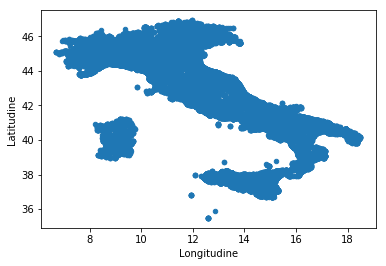

In [14]:
data.iloc[::20, :].plot.scatter("Longitudine", "Latitudine") # Ploting one row every 20 is sufficient to see Italy

### Filtro per le misurazioni degli ultimi 90 giorni

In [15]:
data = data[data["Date"] > data.Date.max() - pd.Timedelta('90 days')].dropna().sort_values(by="Date")

In [16]:
data.Date.min(), data.Date.max()

(Timestamp('2019-01-01 00:00:00'), Timestamp('2019-03-31 00:00:00'))

### Selezione del carburante su cui effettuare previsioni di test

Permette di velocizzare lo studio del miglior modello. Il modello finale includerà in qualche modo anche gli altri carburanti.

In [17]:
data.descCarburante.value_counts().head(10)

Benzina             306781
Gasolio             306065
Blue Diesel          54300
GPL                  32611
Blue Super           28772
Hi-Q Diesel          20496
Excellium Diesel     19130
Gasolio Premium      18564
Metano               11528
HiQ Perform+          7916
Name: descCarburante, dtype: int64

In [18]:
carburante = "Benzina"

In [19]:
data = data[data["descCarburante"] == carburante]

In [20]:
data.descCarburante.value_counts().head(10)

Benzina                 306781
Metano                       0
F101                         0
Excellium Diesel             0
E-DIESEL                     0
DieselMax                    0
Diesel e+10                  0
Diesel Shell V Power         0
Blue Super                   0
Blue Diesel                  0
Name: descCarburante, dtype: int64

### Analisi dell'area geografica di ciascun distributore
Utile per mostrare heatmaps dell'italia divisa in settori.

In [21]:
data["SettoreLat"] = pd.cut(data.Latitudine, 40)

In [22]:
data["SettoreLon"] = pd.cut(data.Longitudine, 40)

In [23]:
data.groupby(["SettoreLat", "SettoreLon"]).ngroups # Settori attivi in italia (non mare, non estero, non inattivo)

505

### Selezione dei fornitori di interesse
Selezioniamo solamente i distributori che hanno fornito dati a sufficienza per applicare un algoritmo predittivo (ossia almeno una misurazione per n giorni tra gli ultimi 3 mesi).

In [24]:
# Ad esempio n=10
data = data[data.groupby(["Bandiera", "isSelf", "Latitudine", "Longitudine"])["Date"].transform(lambda c: c.nunique()) > 10]

In [25]:
data.groupby(["SettoreLat", "SettoreLon", "Bandiera"]).ngroups # Settori italiani x Bandiere rimaste dopo il filtro

1404

## Osservazione dei dati elaborati

In [26]:
data.prezzo.describe()

count    36973.000000
mean         1.532695
std          0.085747
min          0.976000
25%          1.479000
50%          1.519000
75%          1.559000
max          2.099000
Name: prezzo, dtype: float64

#### Prezzo medio del carburante nell'ultimo giorno

In [27]:
data[data.Date == data.Date.min()].prezzo.mean()

1.4876805970149256

In [28]:
data[data.Date == data.Date.max()].prezzo.mean()

1.5429599999999999

#### Boxplot dei 6 fornitori più ricorrenti nel database

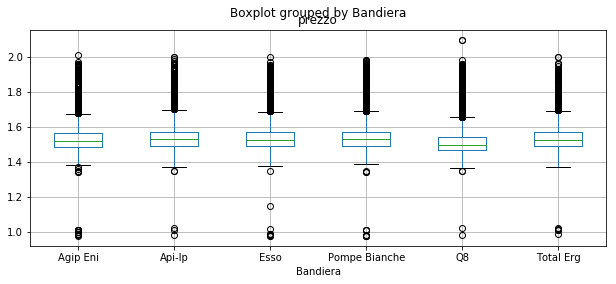

In [29]:
plotdata = data[data.Bandiera.isin(data.groupby("Bandiera").size().sort_values(ascending=False).head(6).reset_index().Bandiera)]
plotdata.Bandiera = plotdata.Bandiera.cat.remove_unused_categories()
plotdata.boxplot(column="prezzo", by="Bandiera", figsize=(10, 4))

#### Heat map dei prezzi medi degli ultimi 5 giorni dei fornitori più attivi

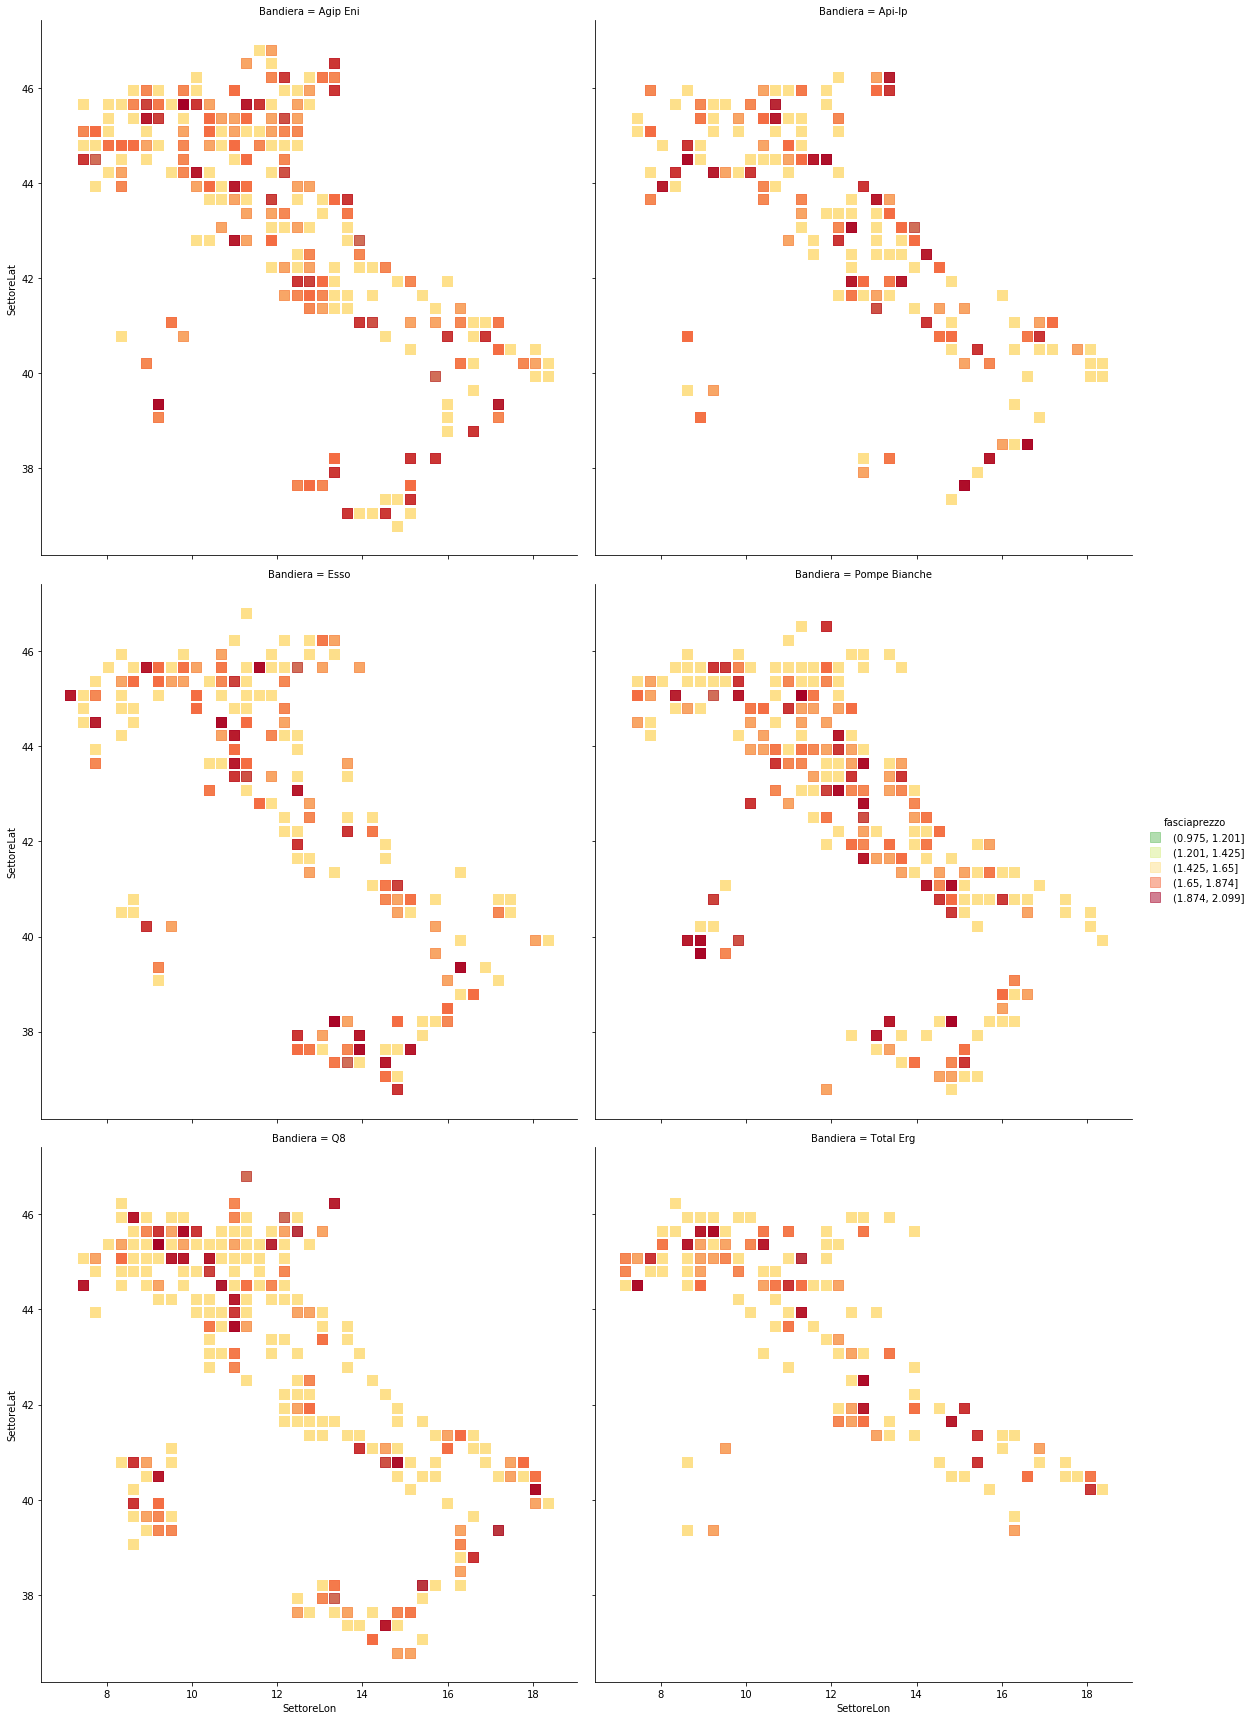

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import RdYlGn
def get_n_colors(n):
    return[ RdYlGn(float(n-i-1)/n) for i in range(n) ]
plotdata = data[(data.Date > data.Date.max() - pd.Timedelta('5 days'))].copy()
plotdata = data[data.Bandiera.isin(data.groupby("Bandiera").size().sort_values(ascending=False).head(6).reset_index().Bandiera)]
plotdata.Bandiera = plotdata.Bandiera.cat.remove_unused_categories()
plotdata["SettoreLat"] = data["SettoreLat"].apply(lambda r: r.mid)
plotdata["SettoreLon"] = data["SettoreLon"].apply(lambda r: r.mid)
plotdata["fasciaprezzo"] = pd.cut(plotdata["prezzo"], 5)
fasceprezzo = plotdata["fasciaprezzo"].sort_values().unique()
colors = get_n_colors(len(fasceprezzo))
g = sns.FacetGrid(plotdata, col="Bandiera", hue="fasciaprezzo", hue_order=fasceprezzo, palette=colors, col_wrap=2, height=8)
g.map(plt.scatter, "SettoreLon", "SettoreLat", alpha=.5, s=100, marker="s")
g.add_legend();

#### Confronto delle variazioni di prezzi nel tempo dei fornitori più attivi e per il carburante scelto

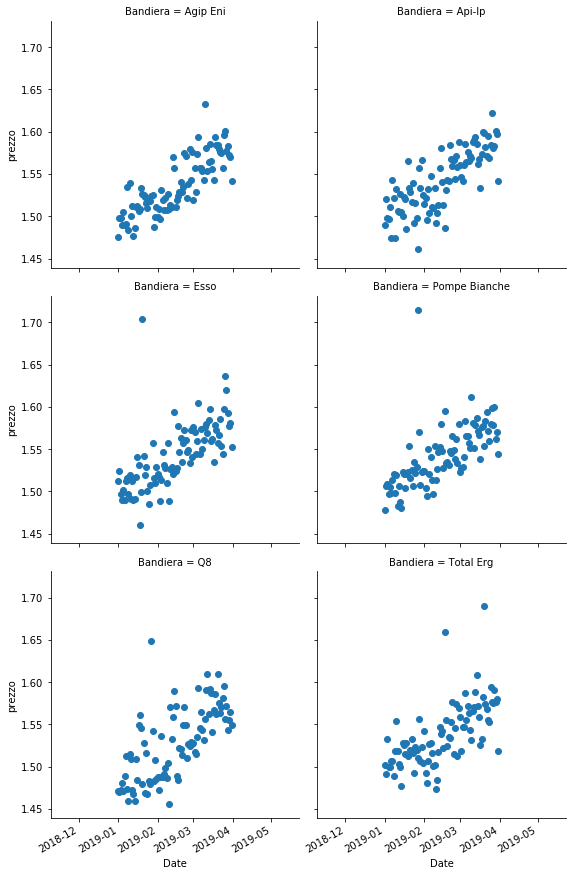

In [31]:
plotdata = data[data.Bandiera.isin(data.groupby("Bandiera").size().sort_values(ascending=False).head(6).reset_index().Bandiera)]
plotdata.Bandiera = plotdata.Bandiera.cat.remove_unused_categories()
g = sns.FacetGrid(plotdata.groupby(["Bandiera", "Date"])["prezzo"].mean().reset_index(), col="Bandiera", col_wrap=2, height=4)
g.map(plt.scatter, "Date", "prezzo")
for ax in g.axes.flatten():
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
g.add_legend();

# Elaborazione di un modello

#### Opzione 1: Un singolo modello

Abbiamo provato ad addestrare un unico modello che prevedesse il prezzo della benzina per un qualsiasi benzinaio (Bandiera), in una qualsiasi posizione, sia self-service che servito, per una qualsiasi data nel futuro. Il dataset però ha dimensioni che non consentono regressioni polinomiali di grado superiore al terzo. Infatti ogni categorico diventerebbe tante colonne quanti sono i valori unici di quella categoria.

#### Opzione 2: Un modello per un sottogruppo dei dati

L'idea che potrebbe risolvere il problema delle dimensioni del dataset sfrutta il principio _divide et impera_, ossia suddividere in "gruppi" il dataset e creare un modello per ciascuno. Da un certo punto di vista abbiamo già fatto la stessa cosa quando abbiamo selezionato un solo carburante e abbiamo pensato di creare un modello per ogni carburante di interesse. La differenza è che ora i gruppi non sono singoli valori di un categorico ma combinazioni cartesiane non vuote di una o più colonne del dataset.

Usando i categorici per individuare i gruppi risparmiamo la creazione delle colonne per ciascun valore assunto da questi e manteniamo matrici dense sia per il training che per la validation dei modelli.

# Opzione 1

Dato che il numero di bandiere è estremamente elevato e rende impossibile la trasformazione del categorico in colonne, è stato ridotto alle n più presenti.

In [32]:
opt1data = data[data.Bandiera.isin(data.groupby("Bandiera").size().sort_values(ascending=False).head(6).reset_index().Bandiera)]
opt1data.Bandiera = opt1data.Bandiera.cat.remove_unused_categories()

Trasformazione del categorico Bandiera in colonne e preparazione del training e validation set.

In [33]:
from sklearn.model_selection import train_test_split
X = pd.concat([opt1data[["Latitudine", "Longitudine", "isSelf", "timestamp"]], opt1data.Bandiera.str.get_dummies()], axis=1)
#X = data[["Latitudine", "Longitudine", "isSelf", "timestamp"]]
y = opt1data["prezzo"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

## Regressione Lineare

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)

Funzioni utili per valutare un modello.

In [35]:
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [36]:
def print_eval(X, y, model):
    print("   Mean squared error: {:.5}".format(mean_squared_error(model.predict(X), y)))
    print("       Relative error: {:.5%}".format(relative_error(model.predict(X), y)))
    print("R-squared coefficient: {:.5}".format(model.score(X, y)))

Creazione del modello tramite pipeline.

In [37]:
from sklearn.pipeline import Pipeline
prm = Pipeline([
    ("linreg", LinearRegression())
])

In [38]:
prm.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('linreg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [39]:
print_eval(X_train, y_train, prm)

   Mean squared error: 0.0046667
       Relative error: 2.87883%
R-squared coefficient: 0.3319


In [40]:
print_eval(X_val, y_val, prm)

   Mean squared error: 0.0050721
       Relative error: 2.96099%
R-squared coefficient: 0.32544


Analisi dei coefficienti ottenuti.

In [41]:
for t in list(zip(["Latitudine", "Longitudine", "isSelf", "timestamp"]+(opt1data.Bandiera.unique().tolist()), prm.named_steps["linreg"].coef_)):
    print(t)

('Latitudine', -0.000855641215027173)
('Longitudine', -0.00011602839713261323)
('isSelf', -0.12608343050501158)
('timestamp', 1.2858072415258609e-08)
('Q8', 0.0005363690452409251)
('Api-Ip', 0.0042858658636402034)
('Total Erg', 0.003669122724945615)
('Pompe Bianche', 0.004142396928205777)
('Agip Eni', -0.014963197225712887)
('Esso', 0.0023294426636803803)


Si può osservare che i coefficienti non assumono valori tali da rendere utile una regolarizzazione L2.

## Regressione con regolarizzazione Lasso (L1)

In [42]:
prm = Pipeline([
    ("scale",  StandardScaler()),
    ("reg", Lasso(alpha=0.0005))
])

In [43]:
prm.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [44]:
print_eval(X_train, y_train, prm)

   Mean squared error: 0.0046683
       Relative error: 2.88306%
R-squared coefficient: 0.33167


In [45]:
print_eval(X_val, y_val, prm)

   Mean squared error: 0.0050712
       Relative error: 2.96428%
R-squared coefficient: 0.32556


In [46]:
for t in list(zip(["Latitudine", "Longitudine", "isSelf", "timestamp"]+(opt1data.Bandiera.unique().tolist()), prm.named_steps["reg"].coef_)):
    print(t)

('Latitudine', -0.0015482175111577135)
('Longitudine', 0.0)
('isSelf', -0.03690220274386576)
('timestamp', 0.02793368921523116)
('Q8', -0.0005327370502595382)
('Api-Ip', 7.752059125515165e-05)
('Total Erg', 0.0)
('Pompe Bianche', 0.00012588509361438868)
('Agip Eni', -0.007649857501674246)
('Esso', -0.0)


Si può notare che le colonne isSelf e timestamp sono i principali fattori determinanti per il prezzo.
Inoltre alcune bandiere sono difficili da distinguere tra loro poichè possiedono coefficienti identici o simili, anche grazie alla regressione Lasso.

## Regressione Polinomiale
### Grado 2

In [47]:
prm = Pipeline([
    ("scale",  StandardScaler()),
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ("linreg", LinearRegression())
])

In [48]:
prm.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('linreg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [49]:
print_eval(X_train, y_train, prm)

   Mean squared error: 0.0046135
       Relative error: 2.85596%
R-squared coefficient: 0.3395


In [50]:
print_eval(X_val, y_val, prm)

   Mean squared error: 0.0050648
       Relative error: 2.95162%
R-squared coefficient: 0.32641


In [51]:
prm.named_steps["linreg"].coef_

array([-1.52935613e-03, -9.99953323e-05,  2.32883256e+11,  2.85340743e-02,
        3.63736879e+09, -3.98568702e+10,  2.79527894e+10, -8.01094333e+10,
       -6.77012467e+10, -4.97353772e+10,  4.30663768e-04,  5.64178105e-04,
        2.64741286e-04,  9.30405767e-04,  4.62455482e+10,  3.81402784e+10,
        3.66663418e+10,  4.38670038e+10,  5.15796628e+10,  3.24942610e+10,
        2.08747901e-04,  8.89085807e-04,  1.48967607e-03,  3.27776485e+10,
        2.70328428e+10,  2.59881547e+10,  3.10917977e+10,  3.65583309e+10,
        2.30310917e+10,  8.55006450e+10,  1.28588567e-03,  5.02493985e+08,
        4.14423901e+08,  3.98408429e+08,  4.76649244e+08,  5.60453305e+08,
        3.53075514e+08,  4.54616547e-03,  1.22978410e+11,  1.01424482e+11,
        9.75049186e+10,  1.16653269e+11,  1.37163147e+11,  8.64103184e+10,
       -1.64981545e+10, -3.13873375e+10,  3.58525673e+10, -2.47702287e+10,
       -8.97124104e+09, -1.18400126e+11, -1.53227097e+10,  2.41523049e+09,
        9.32451111e+10, -

### Grado 3

In [52]:
prm = Pipeline([
    ("scale",  StandardScaler()),
    ("poly",   PolynomialFeatures(degree=3, include_bias=False)),
    ("linreg", LinearRegression())
])

In [53]:
prm.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly', PolynomialFeatures(degree=3, include_bias=False, interaction_only=False)), ('linreg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [54]:
print_eval(X_train, y_train, prm)

   Mean squared error: 0.0045762
       Relative error: 2.84092%
R-squared coefficient: 0.34485


In [55]:
print_eval(X_val, y_val, prm)

   Mean squared error: 0.0050594
       Relative error: 2.94851%
R-squared coefficient: 0.32713


##### Conclusione
Questo modello produce risultati migliori del precedente.

### Grado maggiore di 3
Con un grado superiore a 3 risulta eccessiva l'occupazione in memoria.

### Grado 3 con Regolarizzazione

In [56]:
prm = Pipeline([
    ("scale",  StandardScaler()),
    ("poly",   PolynomialFeatures(degree=3, include_bias=False)),
    ("lasso", Lasso(alpha=0.005))
])

In [57]:
prm.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly', PolynomialFeatures(degree=3, include_bias=False, interaction_only=False)), ('lasso', Lasso(alpha=0.005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [58]:
print_eval(X_train, y_train, prm)

   Mean squared error: 0.0047067
       Relative error: 2.92608%
R-squared coefficient: 0.32616


In [59]:
print_eval(X_val, y_val, prm)

   Mean squared error: 0.0051409
       Relative error: 3.01277%
R-squared coefficient: 0.31629


In [60]:
# Numero di coefficienti <> 0 vs. numero di coefficienti == 0 dopo la lasso
np.count_nonzero(prm.named_steps["lasso"].coef_), np.count_nonzero(prm.named_steps["lasso"].coef_ == 0)

(14, 271)

##### Conclusione
La lasso ha eliminato numerose feature della polinomiale di terzo grado, la precisione è diminuita ma il modello è più generale.

### k-Fold Cross Validation

In [61]:
from sklearn.model_selection import KFold
kf = KFold(5, shuffle=True, random_state=42)

In [62]:
from sklearn.model_selection import cross_val_score
model = Pipeline([
    ("poly",   PolynomialFeatures(degree=3, include_bias=False)),
    ("scale",  StandardScaler()),
    #("linreg", LinearRegression())
    ("lasso'", Lasso(alpha=0.005))
])
scores = cross_val_score(model, X, y, cv=kf)

In [63]:
scores

array([0.30505151, 0.32113405, 0.3216942 , 0.32905736, 0.33155417])

In [64]:
scores.mean(), scores.std()

(0.32169825671662056, 0.009259892700008246)

Osserviamo che ottenendo una deviazione standard di 0.009 possiamo vantare una elevata robustezza.

# Opzione 2

Per poter produrre più modelli che si occupano di sottoinsiemi disgiunti dei dati usiamo le funzionalità di raggruppamento di pandas.

## Preparazione dei set di training e validation
Dividiamo il dataset in n gruppi per semplificare ciascuno degli n modelli corrispondenti.

In [108]:
g = data.groupby(["Bandiera", "isSelf"])

In [66]:
len(g.groups)

106

### Creazione di un modello per ogni gruppo
Costruisco una funzione che crea un dataframe di modelli ognuno dei quali corrisponde ad un gruppo e possiede una colonna per l'errore quadratico medio, l'errore relativo e il punteggio.

In [67]:
from sklearn.model_selection import train_test_split
def store_trained_models(groupdata, data_columns, result_columns, model_trainer):
    result_set = []
    for group_name, group_dataset in groupdata:
        if len(group_dataset) > 0:
            X = group_dataset[data_columns]
            y = group_dataset[result_columns]
            if type(group_name) is not tuple:
                group_name = (group_name,)
            result_set.append(group_name + model_trainer(X, y))
    result_dataframe = pd.DataFrame(data=result_set, columns=groupdata.grouper.names + ["model", "mean_squared_error", "relative_error", "score"])
    return result_dataframe

Costruisco una funzione che prende un dataframe di modelli, identifica il gruppo corrispondente ad un record e fa una previsione usando il modello corrispondente a quel gruppo, passandogli le colonne di dati specificate.

In [68]:
def predict_from_group(trained_models, data_rows, data_columns):
    group_index = trained_models.columns.drop(["model", "mean_squared_error", "relative_error", "score"]).tolist()
    def predict_adapter(_model, _input):
        try:
            return _model.predict([_input])[0]
        except:
            try:
                return _model.predict(np.array(_input, ndmin=2))[0]
            except:
                return _model.predict([_input])
    return pd.merge(data_rows, trained_models, on=group_index, how='inner').apply(lambda row: predict_adapter(row["model"], row[data_columns]), axis=1)

## Regressione Lineare

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Definisco la strategy di training per la regressione lineare e i relativi punteggi.

In [70]:
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))
def lin_train(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    mse = mean_squared_error(y_val, pred)
    re = relative_error(y_val, pred)
    score = model.score(X, y)
    return model, mse, re, score

Addestro un modello di regressione lineare per ogni gruppo usando la strategy.

In [71]:
models = store_trained_models(g, ["Latitudine", "Longitudine", "timestamp"], "prezzo", lin_train)

Effettuo qualche previsione di prova.

In [72]:
predict_from_group(models, data.head(10), ["Latitudine", "Longitudine", "timestamp"])

0    1.457437
1    1.444080
2    1.445284
3    1.474325
4    1.483659
5    1.480353
6    1.482295
7    1.475882
8    1.481335
9    1.485691
dtype: float64

### Problema: come valutare nel complesso tutti i modelli?

In [73]:
models.head(5)

Bandiera  isSelf  \
0         AF Petroli   False   
1         AF Petroli    True   
2            ALIFUEL   False   
3                 AP    True   
4  Adamo Idrocarburi    True   

                                               model  mean_squared_error  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...            0.065241   
1  LinearRegression(copy_X=True, fit_intercept=Tr...            0.003232   
2  LinearRegression(copy_X=True, fit_intercept=Tr...            0.020466   
3  LinearRegression(copy_X=True, fit_intercept=Tr...            0.002400   
4  LinearRegression(copy_X=True, fit_intercept=Tr...            0.004357   

   relative_error     score  
0        0.122926  0.041396  
1        0.030482  0.011631  
2        0.083228 -0.065029  
3        0.023711  0.082151  
4        0.032582  0.155745

In [74]:
models.shape

(106, 6)

#### Definisco un criterio di valutazione del macromodello che faccia da metro di confronto tra i possibili modelli impiegati

Ad esempio l'errore quadratico medio per un validation set creato ad hoc.

In [75]:
def mean_squared_error_from_group(models, data, data_columns, prediction_column):
    return mean_squared_error(data[[prediction_column]].iloc[:,0], predict_from_group(models, data, data_columns))

In [76]:
mean_squared_error_from_group(models, data.sample(200, random_state=42), ["Latitudine", "Longitudine", "timestamp"], "prezzo")

0.008836796207895473

#### Per poter mostrare i dati in un grafico creo una classe che implementa il metodo predict tipicamente usato in scikit-learn

In [77]:
class GroupModelAdapter:
    model = None
    dc = None
    def __init__(self, macromodel, data_columns):
        self.model = macromodel
        self.dc = data_columns
    def predict(self, data):
        return predict_from_group(self.model, data, self.dc)

In [78]:
model = GroupModelAdapter(models, ["Latitudine", "Longitudine", "timestamp"])

#### Creo una funzione per poter visualizzare i modelli sui dati di alcuni distributori delle bandiere più rilevanti

In [79]:
def plot_data(source, model=None, flag_count=5):
    fn = lambda obj: obj.loc[np.random.choice(obj.index, 1, False),:] 
    # Prendo un distributore a caso per ogmi gruppo
    plotdata = source[source.isSelf == False].groupby(["Bandiera", "Date"], as_index=False).apply(fn).dropna()
    # Mostro solamente le bandiere più presenti
    plotdata = plotdata[plotdata.Bandiera.isin(plotdata.groupby("Bandiera").size().sort_values(ascending=False).head(flag_count).reset_index().Bandiera)]
    plotdata.Bandiera = plotdata.Bandiera.cat.remove_unused_categories()
    g = sns.FacetGrid(plotdata, col="Bandiera", col_wrap=2, height=4)
    g.map(plt.scatter, "Date", "prezzo")
    for ax in g.axes.flatten():
        plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    g.add_legend()
    if model is not None:
        for b in list(zip(plotdata["Bandiera"].unique(), g.axes.flat)):
            line_x = plotdata[plotdata.Bandiera == b[0]]
            line_x["y"] = list(model.predict(line_x)) #wtf
            b[1].plot(line_x["Date"], line_x["y"], c="red", lw=2)

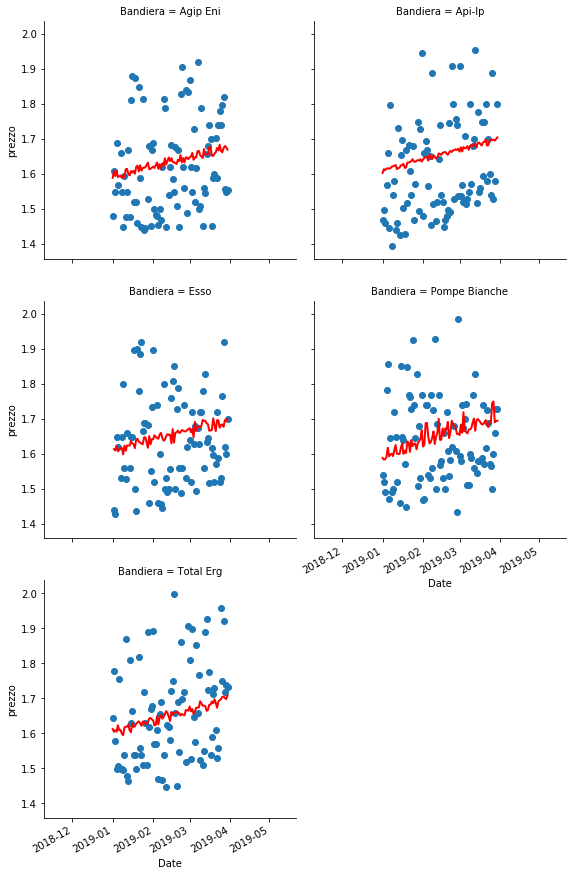

In [80]:
plot_data(data, model)

#### Creo una seconda funzione che permette di visualizzare il modello sui dati di un singolo distributore per ogniuna delle bandiere rilevanti

In [81]:
def plot_data_single(source, model=None, flag_count=5):
    plotdata = source[source.isSelf == False]
    # Mostro solamente le bandiere più presenti
    plotdata = plotdata[plotdata.Bandiera.isin(plotdata.groupby("Bandiera").size().sort_values(ascending=False).head(flag_count).reset_index().Bandiera)]
    plotdata.Bandiera = plotdata.Bandiera.cat.remove_unused_categories()
    data2 = plotdata.dropna().groupby(["Bandiera"]).first().reset_index()
    def check(row, col):
        try:
            return ( row[col] == data2[data2.Bandiera == row.Bandiera][col] ).tolist()[0]
        except:
            return False
    # Mostro solamente i dati di un singolo distributore
    plotdata = plotdata[plotdata.apply(lambda row: check(row, "Latitudine") and check(row, "Longitudine"), axis=1)]
    g = sns.FacetGrid(plotdata, col="Bandiera", col_wrap=2, height=4)
    g.map(plt.scatter, "Date", "prezzo")
    for ax in g.axes.flatten():
        plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    g.add_legend()
    if model is not None:
        for b in list(zip(plotdata["Bandiera"].unique(), g.axes.flat)):
            line_x = plotdata[plotdata.Bandiera == b[0]]
            line_x["y"] = list(model.predict(line_x))
            b[1].plot(line_x["Date"], line_x["y"], c="red", lw=2)

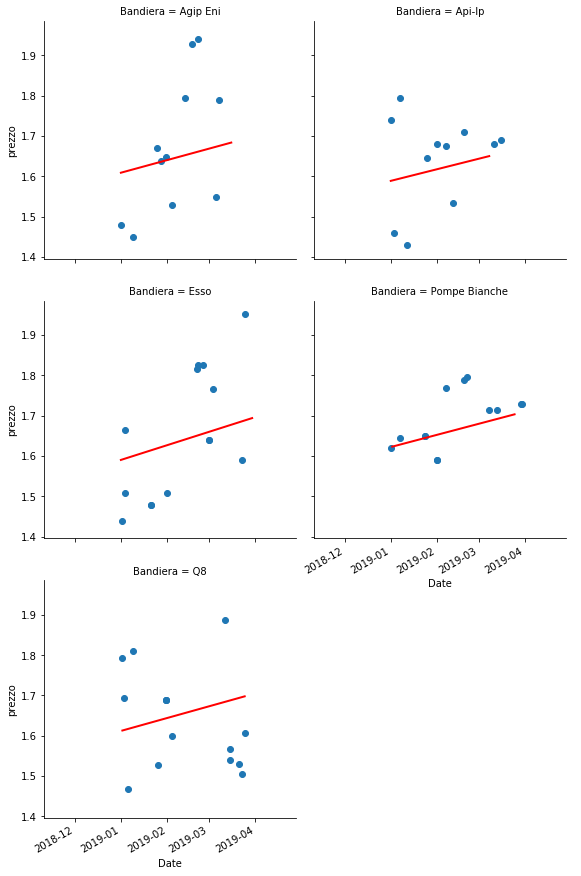

In [82]:
plot_data_single(data, model)

## Regressione Polinomiale

In [83]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

In [84]:
prm = Pipeline([
    # nome     elemento
    ("scale",  StandardScaler()),
    ("poly",   PolynomialFeatures(degree=3, include_bias=False)),
    ("linreg", LinearRegression())
])

In [85]:
def scale_pol_train(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)
    model = Pipeline([
        # nome     elemento
        ("poly",   PolynomialFeatures(degree=3, include_bias=False)),
        ("linreg", LinearRegression())
    ])
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    mse = mean_squared_error(y_val, pred)
    re = relative_error(y_val, pred)
    score = model.score(X, y)
    return model, mse, re, score

In [86]:
pol_models = store_trained_models(g, ["Latitudine", "Longitudine", "timestamp"], "prezzo", scale_pol_train)

In [87]:
mean_squared_error_from_group(pol_models, data.sample(200, random_state=42), ["Latitudine", "Longitudine", "timestamp"], "prezzo")

0.008827269523246058

In [88]:
model = GroupModelAdapter(pol_models, ["Latitudine", "Longitudine", "timestamp"])

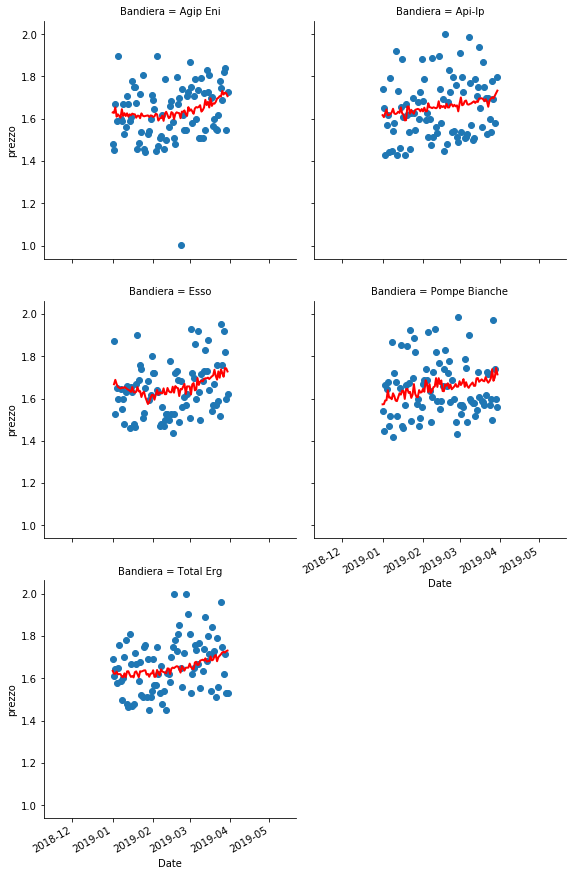

In [89]:
plot_data(data, model)

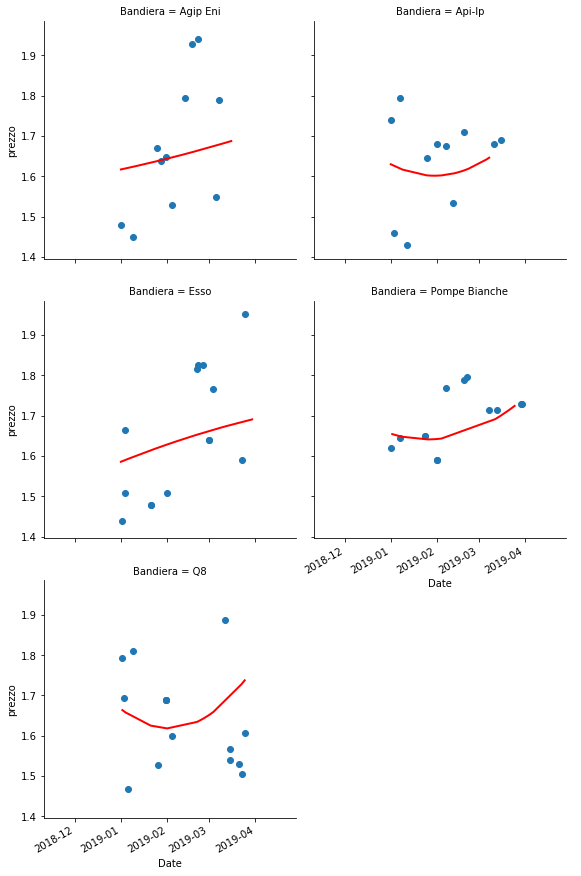

In [90]:
plot_data_single(data, model)

### K-Fold Cross Validation
Per valutare meglio i modelli raggruppati è possibile usare il k-Fold Cross Validation dentro il generatore e ritornare il punteggio medio ottenuto.
Abbiamo osservato che alcuni gruppi contengono troppi pochi dati per utilizzare un numero alto di fold.

In [109]:
kf = KFold(3, shuffle=True, random_state=42)

In [110]:
def scale_pol_train_kcross(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)
    model = Pipeline([
        # nome     elemento
        ("poly",   PolynomialFeatures(degree=3, include_bias=False)),
        ("linreg", LinearRegression())
    ])
    scores = cross_val_score(model, X, y, cv=kf)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    mse = mean_squared_error(y_val, pred)
    re = relative_error(y_val, pred)
    score = scores.mean()
    return model, mse, re, score

In [112]:
store_trained_models(g, ["Latitudine", "Longitudine", "timestamp"], "prezzo", scale_pol_train_kcross).head(5)

Bandiera  isSelf  \
0         AF Petroli   False   
1         AF Petroli    True   
2            ALIFUEL   False   
3                 AP    True   
4  Adamo Idrocarburi    True   

                                               model  mean_squared_error  \
0  Pipeline(memory=None,\n     steps=[('poly', Po...            0.133081   
1  Pipeline(memory=None,\n     steps=[('poly', Po...            0.003162   
2  Pipeline(memory=None,\n     steps=[('poly', Po...            0.026274   
3  Pipeline(memory=None,\n     steps=[('poly', Po...            0.002350   
4  Pipeline(memory=None,\n     steps=[('poly', Po...            0.012206   

   relative_error     score  
0        0.148391 -0.949007  
1        0.030290 -0.152968  
2        0.089741 -1.352584  
3        0.023485 -0.583926  
4        0.051390 -1.357202

## Merge dei modelli migliori per ogni gruppo

In [94]:
best_models = models.copy()
best_models.loc[models["mean_squared_error"] > pol_models["mean_squared_error"], ["model", "mean_squared_error", "relative_error", "score"]] = pol_models[["model", "mean_squared_error", "relative_error", "score"]]
best_models.head(10)

Bandiera  isSelf  \
0         AF Petroli   False   
1         AF Petroli    True   
2            ALIFUEL   False   
3                 AP    True   
4  Adamo Idrocarburi    True   
5           Agip Eni   False   
6           Agip Eni    True   
7             Api-Ip   False   
8             Api-Ip    True   
9             Aquila   False   

                                               model  mean_squared_error  \
0  LinearRegression(copy_X=True, fit_intercept=Tr...            0.065241   
1  Pipeline(memory=None,\n     steps=[('poly', Po...            0.003162   
2  LinearRegression(copy_X=True, fit_intercept=Tr...            0.020466   
3  Pipeline(memory=None,\n     steps=[('poly', Po...            0.002350   
4  LinearRegression(copy_X=True, fit_intercept=Tr...            0.004357   
5  LinearRegression(copy_X=True, fit_intercept=Tr...            0.014086   
6  Pipeline(memory=None,\n     steps=[('poly', Po...            0.004348   
7  LinearRegression(copy_X=True, fit_intercept=Tr...            0.016892   
8  Pipeline(memory=None,\n     steps=[('poly', Po...            0.002877   
9  LinearRegression(copy_X=True, fit_intercept=Tr...            0.023444   

   relative_error     score  
0        0.122926  0.041396  
1        0.030290  0.024504  
2        0.083228 -0.065029  
3        0.023485  0.092746  
4        0.032582  0.155745  
5        0.061441  0.042898  
6        0.026965  0.158062  
7        0.068308  0.026247  
8        0.024726  0.211724  
9        0.074780  0.104910

## Machine Learning

Si tenta di migliorare il risultato analizzando modelli basati sul machine learning e su una nuova divisione in gruppi.

In [95]:
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


La nuova suddivisione consiste nella sola separazione tra self-service e serviti, in quanto ci aspettiamo modelli sufficientemente complessi da essere in grado di gestire le bandiere come colonne categoriche.

In [96]:
mldata = data.copy()
mldata = pd.concat([mldata, pd.get_dummies(mldata["Bandiera"])], axis=1)
g = mldata.groupby(["isSelf"])
g.ngroups
g.head(5)

Bandiera Provincia  Latitudine  Longitudine descCarburante  \
906117             Q8        PA   38.048297    13.390603        Benzina   
906678         Api-Ip        PD   45.248085    12.137554        Benzina   
906680      Total Erg        PD   45.265161    12.116285        Benzina   
906739  Pompe Bianche        PD   45.247343    11.753468        Benzina   
906837       Agip Eni        PD   45.354140    11.896145        Benzina   
904712         Api-Ip        MO   44.658655    10.895196        Benzina   
19651         TEnergy        TP   37.726393    12.886701        Benzina   
18219          Api-Ip        SV   44.123716     8.211779        Benzina   
14136          Tamoil        PT   43.889239    10.962991        Benzina   
13830        Agip Eni        PO   43.919370    11.036542        Benzina   

        isSelf  prezzo       Date     timestamp        SettoreLat  ...  \
906117    True   1.549 2019-01-01  1.546301e+09  (37.789, 38.075]  ...   
906678    True   1.449 2019-01-01  1.546301e+09   (45.23, 45.516]  ...   
906680    True   1.469 2019-01-01  1.546301e+09   (45.23, 45.516]  ...   
906739    True   1.419 2019-01-01  1.546301e+09   (45.23, 45.516]  ...   
906837    True   1.509 2019-01-01  1.546301e+09   (45.23, 45.516]  ...   
904712   False   1.739 2019-01-01  1.546301e+09  (44.657, 44.944]  ...   
19651    False   1.688 2019-01-01  1.546301e+09  (37.503, 37.789]  ...   
18219    False   1.469 2019-01-01  1.546301e+09  (44.085, 44.371]  ...   
14136    False   1.643 2019-01-01  1.546301e+09  (43.799, 44.085]  ...   
13830    False   1.479 2019-01-01  1.546301e+09  (43.799, 44.085]  ...   

       Total Erg  Trivengas  Vega  Verlingas  Win  Xoil  Zannoni  carsie  \
906117         0          0     0          0    0     0        0       0   
906678         0          0     0          0    0     0        0       0   
906680         1          0     0          0    0     0        0       0   
906739         0          0     0          0    0     0        0       0   
906837         0          0     0          0    0     0        0       0   
904712         0          0     0          0    0     0        0       0   
19651          0          0     0          0    0     0        0       0   
18219          0          0     0          0    0     0        0       0   
14136          0          0     0          0    0     0        0       0   
13830          0          0     0          0    0     0        0       0   

        gas e  rosina fuel  
906117      0            0  
906678      0            0  
906680      0            0  
906739      0            0  
906837      0            0  
904712      0            0  
19651       0            0  
18219       0            0  
14136       0            0  
13830       0            0  

[10 rows x 204 columns]

#### Progettazione della rete neurale
- Il numero di epoche è stato fissato a 3 in quanto è stato osservato che dopo la terza epoca la loss rimane pressochè invariata.
- Abbiamo scelto una funzione di attivazione sigmoidale perchè produce risultati migliori delle altre testate (relu, softmax).
- La rete non contiene un numero maggiore di strati in quanto abbiamo osservato che non migliorano i risultati ottenuti.

In [97]:
from keras.wrappers.scikit_learn import KerasRegressor
def ml_train(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)
    def create_model():
        ml = Sequential([
            Dense(len(X.columns), input_dim=len(X.columns), activation="sigmoid"),
            Dense(1)
        ])
        ml.compile(optimizer="adam", loss="mean_squared_error", metrics=['accuracy'])
        return ml
    clf = KerasRegressor(build_fn=create_model, epochs=3)
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("net", clf)
    ])
    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_val) 
    mse = mean_squared_error(y_val, pred)
    re = relative_error(y_val, pred)
    score = pipeline.score(X, y)
    return pipeline, mse, re, score

In [98]:
clist = ["Latitudine", "Longitudine", "timestamp"]
clist.extend(mldata["Bandiera"].unique().tolist())

In [99]:
ml_models = store_trained_models(g, clist, "prezzo", ml_train)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
2590/2590 [==============================] - 1s 216us/step - loss: 0.9656 - acc: 0.0000e+00
Epoch 2/3
2590/2590 [==============================] - 0s 108us/step - loss: 0.0341 - acc: 0.0000e+00
Epoch 3/3
3886/3886 [==============================] - 0s 37us/step
Epoch 1/3
22058/22058 [==============================] - 2s 107us/step - loss: 0.1257 - acc: 0.0000e+00
Epoch 2/3
22058/22058 [==============================] - 2s 89us/step - loss: 0.0037 - acc: 0.0000e+00
Epoch 3/3
33087/33087 [==============================] - 1s 30us/step


In [100]:
predict_from_group(ml_models, mldata.head(10), clist)

0    1.4215344
1    1.5006253
2    1.4857811
3    1.4748328
4    1.4730107
5    1.4483807
6    1.4497021
7     1.445776
8    1.5300254
9    1.4753101
dtype: object

In [101]:
mean_squared_error_from_group(ml_models, mldata.sample(200, random_state=42), clist, "prezzo")

0.009716990387076251

In [102]:
model = GroupModelAdapter(ml_models, clist)

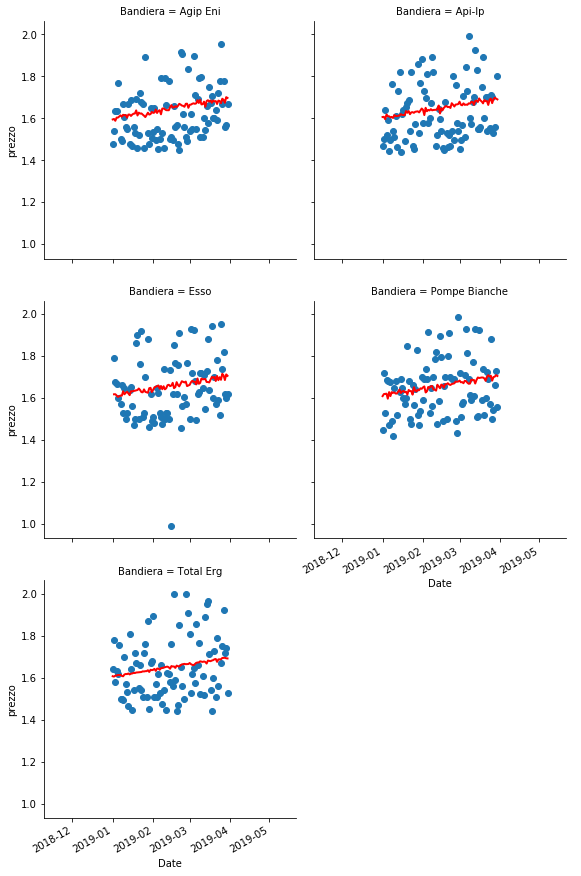

In [103]:
plot_data(mldata, model)

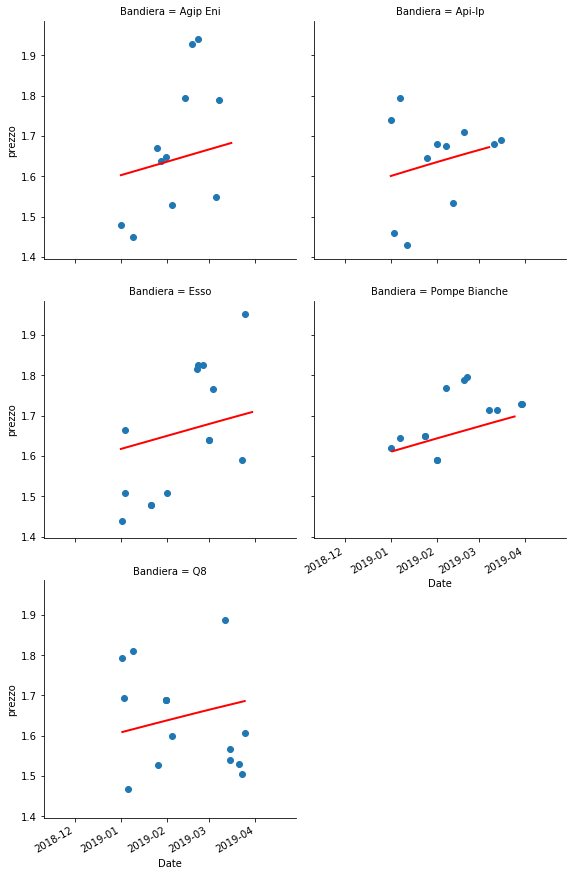

In [104]:
plot_data_single(mldata, model)

# Osservazioni finali
## Studio su un singolo carburante: Benzina
### Previsioni con errori elevati
Dopo la realizzazione dell'applicativo abbiamo testato i nostri modelli. Come era possibile aspettarsi il modello polinomiale e i modelli "merged" che corrispondono a dei modelli polinomiali più ci si allontana dalla data dell'ultimo dato reale più si discostano dal prezzo attuale e corretto della benzina. Questo si deve al fatto che il prezzo della benzina varia in modo più o meno irregolare rispetto al tempo, mantenento una crescita media circa lineare. Di conseguenza qualsiasi funzione polinomiale potrebbe da una parte migliorare la precisione delle previsioni vicine al training set ma dall'altra peggiorare quelle lontane. Di conseguenza il modello lineare si presta meglio a fare previsioni lontane.
### Previsioni di prezzi inferiori a 0
Laddove nel trainset il prezzo di un distributore ha avuto un andamento in decrescita, anche leggera, il modello ha creato una regressione con coefficiente negativo per minimizzare l'errore su quest'ultima. La conseguenza di ciò è che per date lontane dal train set il prezzo della benzina scende sotto lo 0, anche se ovviamente nella realtà ciò non può accadere. Riteniamo che con un train set differente o più ampio questo problema si risolvi in modo banale riallenando il modello.
## Gli altri carburanti
### Altri carburanti nell'opzione 1
Come già anticipato i categorici nell'opzione 1 sono molto più difficili da gestire a causa dell'occupazione in memoria pertanto abbiamo evitato di introdurre altre colonne (centinaia, una per ogni carburante del dataset originale).
### Altri carburanti nell'opzione 2
Arrivati a questo punto abbiamo ritenuto superfluo una ripetizione di tutto il lavoro per gli altri carburanti, in quanto nella pratica basterebbe modificare o rimuovere il filtro della sola Benzina e aggiungere il carburante alla lista delle colonne che determinano i gruppi nell'Opzione 2. Pertanto sia questo documento sia l'applicativo web lavorano solo con la Benzina.
# Conclusioni
Lo studio dei dati e dei modelli ha portato senza dubbio molti risultati interessanti, ma non ha prodotto un modello efficace nel prevedere il prezzo della Benzina nel futuro lontano rispetto al dataset. Nonostante ciò riteniamo che con dati recenti e un modello appena allenato è possibile mantenere un buon grado di accuratezza anche per diversi giorni prima di vedere strani fenomeni (come la benzina gratis).
Lo studio di un modello con il Machine Learning ci è sembrato promettente e forse potrebbe essere la strada migliore per questo tipo di modello nonostante un maggiore errore quadratico medio sul campione di dataset.